In [50]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.path as mplPath
%matplotlib inline

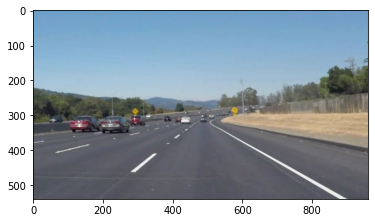

In [51]:
# read image
img=cv2.imread("test_images/solidWhiteCurve.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

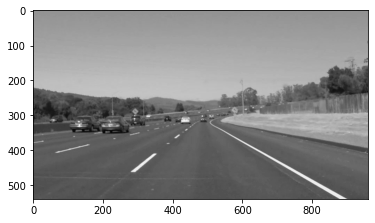

In [52]:
# Gaussian filter
img_gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
img_blur=cv2.GaussianBlur(img_gray,(5,5),10)
plt.imshow(img_gray,cmap="gray")

(540, 960)


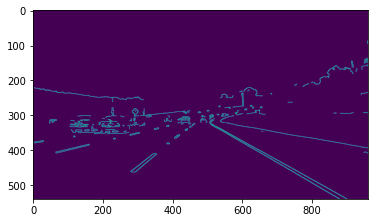

In [53]:
# edge detection
edge=cv2.Canny(img_gray,150,255)
plt.imshow(edge)
print(edge.shape)

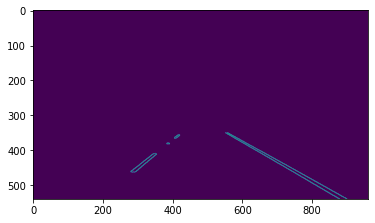

In [54]:
# interest zone
vertices=np.array([[[100,540],[350,350],[700,350],[960,540]]])
def interest_zone(img,vertices):
  mask=np.zeros_like(img)
  color=(255,255,255)
  cv2.fillPoly(mask,vertices,color)
  #returning the image only where mask pixels are nonzero
  res = cv2.bitwise_and(img,mask)
  return res
region=interest_zone(edge,vertices)
plt.imshow(region)

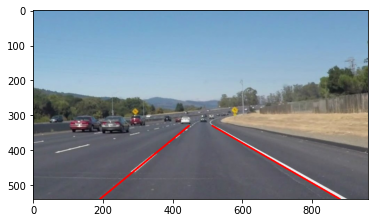

In [55]:
def draw_lines(img, lines, vertices, color=(255, 0, 0), thickness=3):
    
    #[slopeSum, count, yIntersectSum, x, y]
    leftLane = [0, 0, 0, 0, 0]
    rightLane = [0, 0, 0, 0, 0]
    
    # Image dimentions (y, x): 540, 960 
    vertices = np.array([[100,540],[420, 330], [520, 330], [900,540]])
    bbPath = mplPath.Path(vertices)
    
    minX = 100
    maxX = 900
    
    minY = 330
    maxY = 540
    
    # Go through each line and keep track of the slope and y-intersect of each line
    # we will average these out later to obtain the lane marking.
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            # Only calculate slope if it's within our bounded region
            if (bbPath.contains_point([x1, y1]) is not True):
                continue
                
            m = (y2 - y1) / (x2 - x1)
            b = y1 - (m * x1)
            if (m > 0):
                rightLane[0] = rightLane[0] + m
                rightLane[1] += 1
                rightLane[2] += b
                rightLane[3] = x1
                rightLane[4] = y1
            else:
                leftLane[0] = leftLane[0] + m
                leftLane[1] += 1
                leftLane[2] += b
                leftLane[3] = x1
                leftLane[4] = y1
    left_lane_slope = 0
    left_lane_y_intercept = 0
    right_lane_slope = 0
    right_lane_y_intercept = 0
    
    global last_slope_left
    global last_slope_right
    
    if (leftLane[1] != 0):
        left_lane_slope = leftLane[0] / leftLane[1]
        left_lane_y_intercept = leftLane[2] / leftLane[1]
        last_slope_left = left_lane_slope
    else:
        left_lane_slope = last_slope_left
    
    if (rightLane[1] != 0):
        right_lane_slope = rightLane[0] / rightLane[1]
        right_lane_y_intercept = rightLane[2] / rightLane[1]
        last_slope_right = right_lane_slope
    else:
        right_lane_slope = last_slope_right
    
    x_bottom_left_lane = (maxY - left_lane_y_intercept) / left_lane_slope
    y_bottom_left_lane = left_lane_slope * x_bottom_left_lane + left_lane_y_intercept

    
    x_top_left_lane = (minY - left_lane_y_intercept) / left_lane_slope
    y_top_left_lane = left_lane_slope * x_top_left_lane + left_lane_y_intercept
    
    cv2.line(img, (int(round(x_bottom_left_lane)), int(round(y_bottom_left_lane))), (int(round(x_top_left_lane)), int(round(y_top_left_lane))), [255, 0, 0], thickness)
    
    
    minX_right = 100
    maxX_right = 900
    
    minY_right = 330
    maxY_right = 540
    
    x_bottom_right_lane = (maxY_right - right_lane_y_intercept) / right_lane_slope
    y_bottom_right_lane = right_lane_slope * x_bottom_right_lane + right_lane_y_intercept
    
    x_top_right_lane = (minY - right_lane_y_intercept) / right_lane_slope
    y_top_right_lane = right_lane_slope * x_top_right_lane + right_lane_y_intercept
    
    cv2.line(img, (int(round(x_bottom_right_lane)), int(round(y_bottom_right_lane))), (int(round(x_top_right_lane)), int(round(y_top_right_lane))), [255, 0, 0], thickness)


def hough_lines(region,img,rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(region, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    draw_lines(img, lines, [0, 255, 0], 15)
    return img


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)


rho = 1                      # distance resolution in pixels of the Hough grid
theta = np.pi/180            # angular resolution in radians of the Hough grid
threshold = 20               # minimum number of votes (intersections in Hough grid cell)
min_line_len = 30            #minimum number of pixels making up a line
max_line_gap = 3              # maximum gap in pixels between connectable line segments
line=hough_lines(region,img,rho, theta, threshold, min_line_len, max_line_gap)
plt.imshow(line)

In [56]:
def video_process(img):
  global vertices
  img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img_blur=cv2.GaussianBlur(img_gray,(5,5),10) 
  edge=cv2.Canny(img_gray,150,255)
  region=interest_zone(edge,vertices)
  vertices=np.array([[[100,540],[350,350],[700,350],[960,540]]])
  rho = 1                      # distance resolution in pixels of the Hough grid
  theta = np.pi/180            # angular resolution in radians of the Hough grid
  threshold = 20               # minimum number of votes (intersections in Hough grid cell)
  min_line_len = 30            #minimum number of pixels making up a line
  max_line_gap = 3              # maximum gap in pixels between connectable line segments
  line_img=hough_lines(region,img, rho, theta, threshold, min_line_len, max_line_gap)
  return line_img

In [58]:
# video processing 
cap=cv2.VideoCapture("test_videos/solidYellowLeft.mp4")

width=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height=int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'XVID')
writer = cv2.VideoWriter('solidYellowLeft.avi',fourcc, 20.0,(width,height))
while cap.isOpened():
  ret,frame=cap.read()
  if ret==True:

     line_img=video_process(frame)
     writer.write(line_img)
     if cv2.waitKey(1) & 0xFF==ord('q'):
         break
  else:
      break  
cap.release()
writer.release()